In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as nnf
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

C:\Users\Nassim\AppData\Local\Temp\ipykernel_13976\1160388593.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\Nassim\AppData\Local\Temp\ipykernel_13976\1160388593.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


# Preprocessing learning data

In [2]:
path_imgs = r'./data/portraits/'
path_imgs_edited = r'./data/Player_output/Photoshop/'

list_imgs = os.listdir(path_imgs)
list_imgs_edited = os.listdir(path_imgs_edited)

d_imgs = dict() 
d_edited_names = dict()

for img_name in list_imgs : 
    d_imgs[img_name] = np.array(Image.open(path_imgs + img_name))
    
    list_imgs_name_edited = [x for x in list_imgs_edited if x.startswith(img_name[:-4] + "_")]
    d_edited_names[img_name] = list_imgs_name_edited

    for img_name_edited in list_imgs_name_edited : 
        d_imgs[img_name_edited] = np.array(Image.open(path_imgs_edited + img_name_edited))
    



In [3]:
from PIL import Image 
import PIL

save_pair_folder = r"./data/photoshoptest_diff/"

dataset = []
for img in d_edited_names : 
    for edited_img in d_edited_names[img] : 
        d = d_imgs[img] - d_imgs[edited_img]
        dataset.append(d)
        i = Image.fromarray(d)
        i.save(save_pair_folder + edited_img[:-4] + "_diff.jpg")

# Loading data / functions

In [7]:
path_diff_img = 'data/photoshoptest_diff'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_diff_img, transform=image_transform)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


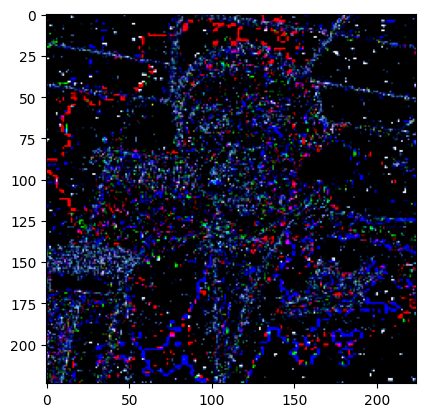

In [8]:
image = dataset[0][0]
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [11]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    #Used to calculate the confusion matrix
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:

            Xd, yd = X.to(device), y.to(device)
            pred = model(Xd)
            
            test_loss += loss_fn(pred, yd).item()
            correct += (pred.argmax(1) == yd).type(torch.float).sum().item()
            
            
            y_pred.extend(pred.argmax(1).data.cpu().numpy())
            y_true.extend(y.data.cpu().numpy())

        

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot()
    plt.xticks(rotation = 45) 
    plt.show()
    

# Training

In [15]:
epochs = 20
torch.cuda.empty_cache()

for i in range(1):
    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print("CrossValidation : "+str(i)+"\n-------------------------------\n")
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


    # Create the data loaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=100,
        shuffle=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=False
    )
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        # test(test_dataloader, model, loss_fn)
    print("Done!")



CrossValidation : 0
-------------------------------

Epoch 1
-------------------------------
loss: 2.087565  [  100/ 2436]
Epoch 2
-------------------------------
loss: 1.601450  [  100/ 2436]
Epoch 3
-------------------------------
loss: 0.675485  [  100/ 2436]
Epoch 4
-------------------------------
loss: 0.580569  [  100/ 2436]
Epoch 5
-------------------------------
loss: 0.332753  [  100/ 2436]
Epoch 6
-------------------------------
loss: 0.208091  [  100/ 2436]
Epoch 7
-------------------------------
loss: 0.190429  [  100/ 2436]
Epoch 8
-------------------------------
loss: 0.126039  [  100/ 2436]
Epoch 9
-------------------------------
loss: 0.100384  [  100/ 2436]
Epoch 10
-------------------------------
loss: 0.067031  [  100/ 2436]
Epoch 11
-------------------------------
loss: 0.028624  [  100/ 2436]
Epoch 12
-------------------------------
loss: 0.005233  [  100/ 2436]
Epoch 13
-------------------------------
loss: 0.001778  [  100/ 2436]
Epoch 14
------------------------

In [16]:
torch.save(model.state_dict(), "./models/model_diff")

# Testing phase

Test Error: 
 Accuracy: 81.6%, Avg loss: 0.577572 



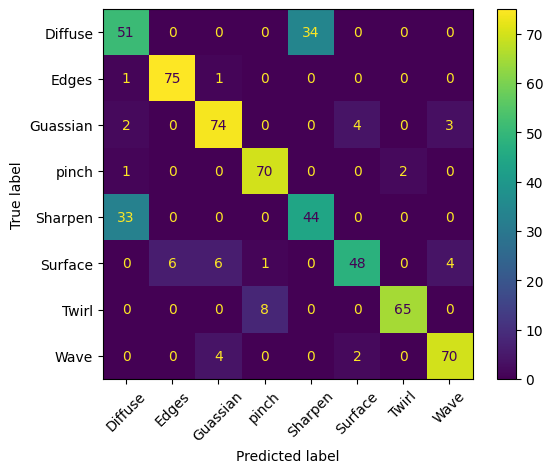

In [17]:
model = LeNet().to(device)
model.load_state_dict(torch.load("./models/model_diff"))
model.eval()
loss_fn = nn.CrossEntropyLoss()

_, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=100,
    shuffle=False
)

test(test_dataloader, model, loss_fn)

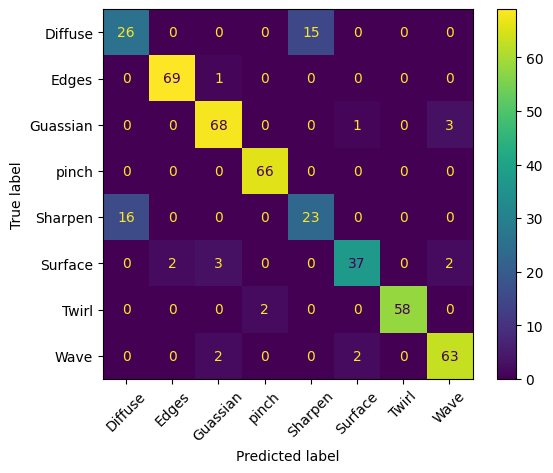

In [18]:
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.90
indices = y_pred.max(1) > seuil
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]

conf_matrix = confusion_matrix(y_true, y_pred)
labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.xticks(rotation = 45) 
plt.show()

# Test unitaire

In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use your normalization values
])

i_org = np.array(Image.open("./data/pair_tmp/edited_sharpen.jpg"))
i_edt = np.array(Image.open("./data/pair_tmp/edited_twirl.jpg"))
i = Image.fromarray(i_org - i_edt)

image_tensor = transform(i).unsqueeze(0)
image_tensor = image_tensor.cuda()

with torch.no_grad() : 
    output = model(image_tensor)

_, predicted_class = torch.max(output, 1)

probas = nnf.softmax(output, dim=1)

print("predicted class : ", predicted_class.item())
print("Proba de prédiction : ", probas[0, predicted_class.item()].item())


predicted class :  1
Proba de prédiction :  0.9999926090240479


In [49]:
import cv2
import numpy as np

def find_edited_areas(image1, image2, threshold=30, min_area=1000):
    diff_image = cv2.absdiff(image1, image2)
    gray_diff = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)
    _, thresholded_diff = cv2.threshold(gray_diff, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]
    bounding_boxes = [cv2.boundingRect(contour) for contour in filtered_contours]
    return bounding_boxes


def bounding_box_from_points(points):
    x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

def find_bb(img_org, img_edt) : 
    image1 = img_org
    image2 = img_edt

    edited_areas = find_edited_areas(image1, image2, min_area=50)

    scale_factor = 1

    min_x = min_y = 100000
    max_x = max_y = 0

    images_list = []

    if len(edited_areas) > 0:
        for i, (x, y, w, h) in enumerate(edited_areas):
            scaled_w = int(w * scale_factor)
            scaled_h = int(h * scale_factor)
            scaled_x = max(0, int(x - (scaled_w - w) / 2))
            scaled_y = max(0, int(y - (scaled_h - h) / 2))

            cropped_image1 = image1[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            cropped_image2 = image2[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            
            final_image_cropped = cropped_image1 - cropped_image2
            images_list.append(final_image_cropped)
            
            if (min_x > scaled_x) : min_x = scaled_x
            if (min_y > scaled_y) : min_y = scaled_y
            if (max_x < scaled_x + scaled_w) : max_x = scaled_x + scaled_w 
            if (max_y < scaled_y + scaled_h) : max_y = scaled_y + scaled_h 


    else:
        return [image1 - image2]

    cropped_image1 = image1[min_y:max_y, min_x:max_x]
    cropped_image2 = image2[min_y:max_y, min_x:max_x]      
    final_image = cropped_image1 - cropped_image2
    images_list.append(final_image)
    return images_list



In [50]:
il = find_bb(i_org, i_edt)
print(len(il))

8
